In [1]:
%pylab inline
import pandas as pd
import numpy as np
import seaborn as sns

sys.path.append('..')
from DegScore import DegScore

from tqdm import tqdm
tqdm.pandas()

Populating the interactive namespace from numpy and matplotlib


## Using DegScore class

In [2]:
mdl = DegScore('GGGUUUCCC', structure='(((...)))')
print(mdl.degscore_by_position)
print(mdl.degscore)
print(mdl.est_half_life)

[0.17  0.217 0.511 0.641 0.714 0.49  0.347 0.15  0.643]
3.8830000000000013
11.430771365678682


Mimicking Pseudouridine (PSU): `mask_U=True` sets DegScore at U's to 0 to mimic stabilization from PSU.

In [34]:
mdl = DegScore('GGGUUUCCC', structure='(((...)))', mask_U=True)
print(mdl.degscore_by_position)
print(mdl.loop_assignments)
print(mdl.degscore)
print(mdl.est_half_life)

[0.17  0.217 0.511 0.    0.    0.    0.347 0.15  0.643]
SSSHHHSSS
2.0380000000000007
12.239219021551373


If only sequence is provided and Arnie is loaded, DegScore will use Arnie to calculate secondary structure and use that in its prediction.

In [4]:
mdl = DegScore('GGGUUUCCC')
print(mdl.structure)
print(mdl.degscore_by_position)
print(mdl.degscore)

(((...)))
[0.17  0.217 0.511 0.641 0.714 0.49  0.347 0.15  0.643]
3.8830000000000013


## Visualize datasets from PERSIST-seq paper

In [3]:
df_ryos = pd.read_json('DEMO_Kaggle_RYOS_train.json')
df_233x = pd.read_json('DEMO_233x.json')
df_24x = pd.read_json('DEMO_24x.json')

def get_degscore_calculations(row, mask_U=False):
    mdl = DegScore(row['sequence'], mask_U = mask_U, start_ind=row['start_pos'], end_ind=row['end_pos'])
    return mdl.degscore, mdl.est_k_deg, mdl.est_half_life

df_ryos[['degscore', 'est_k_deg', 'est_half_life']] = df_ryos.apply(lambda row: get_degscore_calculations(row), axis=1, result_type='expand')
df_233x[['degscore', 'est_k_deg', 'est_half_life']] = df_233x.apply(lambda row: get_degscore_calculations(row), axis=1, result_type='expand')
df_24x[['degscore', 'est_k_deg', 'est_half_life']] = df_24x.apply(lambda row: get_degscore_calculations(row, mask_U=True), axis=1, result_type='expand')

To calibrate the DegScore model to measured degradation rates on full-length mRNAs, we performed a linear fit between predicted DegScore values for 233 mRNAs of varying length, as well as the "Roll-Your-Own Structure" dataset (the filtered training dataset used on Kaggle). The below plot shows the resulting fit of the degradation rate, and the corresponding half-life.

Specifically, `est_k_deg` is calculated as 

```
est_k_deg = m * degscore + b

m = 0.002170959651184987
b = 0.05220886935630193
```

And `est_half_life` is calculated as

```
est_half_life = ln(2) / est_k_deg.
```



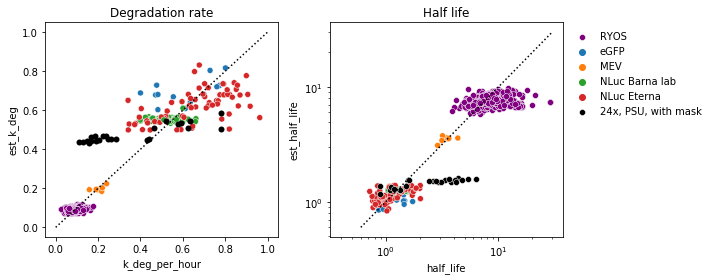

In [37]:
figure(figsize=(10,4))

subplot(1,2,1)
title('Degradation rate')
sns.scatterplot(x='k_deg_per_hour', y='est_k_deg', data=df_ryos, color='purple', label='RYOS')
sns.scatterplot(x='k_deg_per_hour', y='est_k_deg', data=df_233x, hue='Expt type')
sns.scatterplot(x='k_deg per hour', y='est_k_deg', data=df_24x, color='k', linewidth=0, label='24x, PSU, with mask')

plot([0,1],[0,1],color='k',linestyle=':')
legend([],frameon=False)

subplot(1,2,2)
title('Half life')
sns.scatterplot(x='half_life', y='est_half_life', data=df_ryos, color='purple', label='RYOS')
sns.scatterplot(x='half_life', y='est_half_life', data=df_233x, hue='Expt type')
sns.scatterplot(x='half_life', y='est_half_life', data=df_24x, color='k', label='24x, PSU, with mask')
plot([0.6,30],[0.6,30],color='k',linestyle=':')

semilogx()
semilogy()
legend(bbox_to_anchor=(1,1),frameon=False)

tight_layout()

savefig('example_datasets_degscore_predictions.pdf',bbox_inches='tight')

## EternaScript unit tests

In [64]:
# write a random set of short RNAs

with open('rand_seqs.csv','w') as f:
    f.write('sequence\n')
    for _ in range(20):
        f.write("%s\n" % ''.join(np.random.choice(list('ACGU'),size=100)))

In [65]:
# write values for not-masked-U

rand_seqs = pd.read_csv('rand_seqs.csv',delimiter=',')

def get_degscore_calculations(row, mask_U=False):
    mdl = DegScore(row['sequence'], mask_U = mask_U)
    return mdl.degscore, mdl.structure, mdl.loop_assignments, mdl.degscore_by_position, mdl.est_k_deg, mdl.est_half_life

rand_seqs[['degscore','structure','loop_assignments','degscore_by_position','est_k_deg','est_half_life']]\
= rand_seqs.apply(lambda row: get_degscore_calculations(row), axis=1, result_type='expand')

rand_seqs.to_csv('Degscore_unit_tests.csv')


# write unit tests using masked U

rand_seqs = pd.read_csv('rand_seqs.csv',delimiter=',')

rand_seqs[['degscore','structure','loop_assignments','degscore_by_position','est_k_deg','est_half_life']]\
= rand_seqs.apply(lambda row: get_degscore_calculations(row, mask_U=True), axis=1, result_type='expand')

rand_seqs.to_csv('Degscore_unit_tests_mask_U.csv')